In [347]:
import importlib.util
import os
import json
from dotenv import load_dotenv
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from simpleRegArchitecture import SimpleNet

load_dotenv() 

False

In [348]:
NUM_BINS = 5

config_file_path = os.getenv('CONFIG_FILE_PATH')
print(config_file_path)
with open(config_file_path, "r") as f:
    config = json.load(f)

#Load in the networks
output_dir = config.get("output_dir")
loaded_state_dict = torch.load(f'{output_dir}/trainedNetworks.pt')

#create new instantiations to contain the saved networks
num_networks = config.get("num_networks")
networks = []
for n in range(num_networks):
    networks.append(SimpleNet())

for i, network in enumerate(networks):
    state_dict_key = f'network_{i}'
    network.load_state_dict(loaded_state_dict[state_dict_key])




/Users/simoncole/seniorDesign/Large-Scale-Design-and-Analysis-of-Neural-Networks/config.json


In [349]:
layer_weight_distributions = []
layer_bin_ranges = []
network_fc_indices = []
#for each fully connected layer, create matrix of shape (N, M, B) where
#N = num neurons in layer
#M = num neurons in previous layer
#B = number of bins
#generate an array of bin edges based on min and max of the first network(for now)
layers = networks[0].children()
for index, layer in enumerate(layers):
    if isinstance(layer, nn.Linear):
        #for each layer make an array of shape (num of neurons in layer, num of inputs to layer, num of bins)
        network_fc_indices.append(index)
        layer_shape = layer.weight.shape
        layer_weight_distributions.append(np.zeros((NUM_BINS,) + layer_shape, dtype=int))
        #TODO: change to get the true min and max of all networks not just from the first network
        layer_bin_ranges.append(np.histogram_bin_edges(layer.weight.data.numpy().flatten(), bins=(NUM_BINS)))
        
#Generate for each layer a matrix of network, row, column matrix
network_weights = []
for index, layer_index in enumerate(network_fc_indices):
    network_weights_per_layer = []
    for network in networks:
        net_layers = list(network.children())
        network_weights_per_layer.append(net_layers[layer_index].weight.data.numpy())
    network_weights.append(network_weights_per_layer)

print(network_weights[0][0])

[[-0.34732863 -0.69025415]
 [ 0.10069881  0.6371204 ]
 [-0.22167379 -0.47303843]
 [ 0.10396019 -0.50228417]
 [-0.1323322   0.47889856]
 [ 0.16188692 -0.00769379]
 [-0.5548569  -0.3666297 ]
 [-0.6735472   0.28623003]
 [ 0.14287387  0.31472594]
 [ 0.945256   -0.5850819 ]]


In [350]:
#iterating over each layer
for layer_num, layer_distribution in enumerate(layer_weight_distributions):
    #iterate over all the weights in a layer and increment their corresponding index in the bin ranges to the 3D array 
    #select the first bin for iteration, could select any
    for i, row in enumerate(layer_distribution[0]):
        for j, weight_count in enumerate(row):
            #get the matching bin for the value of the weight
            #for this weight position, iterate over each network and select the layer you're already in
            #then get the bin for that weight and increment the corresponding bin and position
            for network in network_weights[layer_num]:
                #includes the left bin edge and excludes the right
                weight = network[i][j]
                corresponding_bin = np.digitize(weight, layer_bin_ranges[layer_num], right=False)
                #in the case the weight is > or < than the min max of the first network (will chnage)
                if weight < layer_bin_ranges[layer_num][0]:
                    corresponding_bin = 0
                elif weight > layer_bin_ranges[layer_num][len(layer_bin_ranges) - 1]:
                    corresponding_bin = len(layer_bin_ranges) - 2
                
                layer_weight_distributions[layer_num][corresponding_bin][i][j] += 1

print(layer_weight_distributions)

[array([[[793, 790],
        [815, 771],
        [817, 777],
        [817, 762],
        [782, 808],
        [831, 787],
        [813, 762],
        [786, 811],
        [816, 787],
        [795, 784]],

       [[207, 210],
        [185, 229],
        [183, 223],
        [183, 238],
        [218, 192],
        [169, 213],
        [187, 238],
        [214, 189],
        [184, 213],
        [205, 216]],

       [[  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0]],

       [[  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0]],

       [[  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  

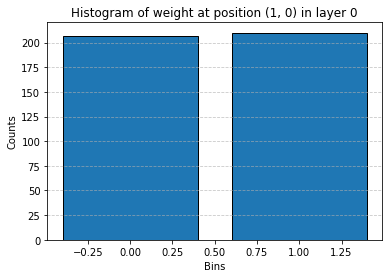

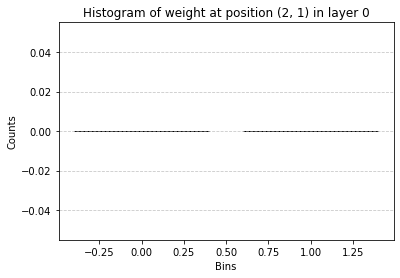

Invalid weight position


In [352]:
def plot_weight_histogram(data, layer_idx, weight_idx):
    try:
        counts = data[layer_idx][weight_idx[0]][weight_idx[1]]
    except IndexError:
        print("Invalid weight position")
        return

    bins = np.arange(len(counts))
    plt.bar(bins, counts, edgecolor='black')
    plt.xlabel('Bins')
    plt.ylabel('Counts')
    plt.title(f'Histogram of weight at position {weight_idx} in layer {layer_idx}')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_weight_histogram(layer_weight_distributions, layer_idx=0, weight_idx=(1, 0))
plot_weight_histogram(layer_weight_distributions, layer_idx=0, weight_idx=(2, 1))
plot_weight_histogram(layer_weight_distributions, layer_idx=1, weight_idx=(0, 5))